__This is a reproduction of "[Scale-Free Networks Provide a Unifying Framework for the Emergence of Cooperation (Santos & Pacheco, 2005)](https://doi-org.ezproxy.tulips.tsukuba.ac.jp/10.1103/PhysRevLett.95.098104)"__

In [1]:
using Agents
using LightGraphs
using Statistics: mean, sum
using Plots
using Test: @test
using DataFrames

In [15]:
println("Julia $VERSION")

Julia 1.6.2


# 1. Define agent

In [3]:
const C = true
const D = false

mutable struct Player <: AbstractAgent
    id::Int
    pos::Int
    strategy::Bool # C or D
    next_strategy::Bool # C or D
    payoff::Float64
    
    Player(id::Int, strategy::Bool) = new(id, id, strategy, D, 0.0)
    Player(id::Int, c_rate::Float64) = new(id, id, rand() < c_rate, D, 0.0)
end

# 2. Define pay-off table

||C|D|
|:-:|:-:|:-:|
|C|R|S|
|D|T|P|

In [4]:
struct PayOffTable
    T::Float64
    R::Float64
    P::Float64
    S::Float64
end

function PayOffTable_PD(b::Float64)::PayOffTable
    PayOffTable(b, 1, 0.00001, 0)
end

function PayOffTable_SD(r::Float64)::PayOffTable
    T = β = (1 / r + 1) / 2
    R = β - 1 / 2
    P = 0
    S = β - 1
    PayOffTable(T, R, P, S)
end

function play(payofftable::PayOffTable, me::Player, you::Player)::Float64
    payoff = nothing
    
    if me.strategy && you.strategy
        payoff = payofftable.R
    elseif me.strategy && !you.strategy
        payoff = payofftable.S
    elseif !me.strategy && you.strategy
        payoff = payofftable.T
    elseif !me.strategy && !you.strategy
        payoff = payofftable.P
    end
    
    return payoff
end

# Test
payofftable_pd = PayOffTable_PD(1.5)
@test play(payofftable_pd, Player(1, C), Player(1, C)) == 1
@test play(payofftable_pd, Player(1, C), Player(1, D)) == 0
@test play(payofftable_pd, Player(1, D), Player(1, C)) == 1.5
@test play(payofftable_pd, Player(1, D), Player(1, D)) == 0.00001

payofftable_sd = PayOffTable_SD(0.5)
@test play(payofftable_sd, Player(1, C), Player(1, C)) == 1
@test play(payofftable_sd, Player(1, C), Player(1, D)) == 0.5
@test play(payofftable_sd, Player(1, D), Player(1, C)) == 1.5
@test play(payofftable_sd, Player(1, D), Player(1, D)) == 0

Test Passed

# 3. Define a function for building model

In [5]:
function build_model(;G::SimpleGraph, payofftable::PayOffTable, c_rate::Float64)
    space = GraphSpace(G)
    model = ABM(Player, space, properties = Dict(:payofftable => payofftable))

    # モデル上にエージェントを配置する。
    for id in 1:nv(G)
        add_agent_pos!(Player(id, c_rate), model)
    end
    
    return model
end

# Test
model = build_model(G = random_regular_graph(104, 4), payofftable = PayOffTable_PD(1.5), c_rate = 0.8)
@test length(allagents(model)) == 104
@test model.properties[:payofftable].T == 1.5

Test Passed

# 4. Define model behavior of 1step

In [6]:
function model_step!(model::AgentBasedModel)
    payofftable = model.properties[:payofftable]
    
    # In each generation, all pairs of individuals x and y, directly connected, engage in a single round of a given game,
    # their accumulated payoffs being stored as Px and Py, respectively.
    for agent in allagents(model)
        agent.payoff = 0
        for neighbor in nearby_agents(agent, model)
            agent.payoff += play(payofftable, agent, neighbor)
        end
        # agent.payoff = sum([play(payofftable, agent, neighbor) for neighbor in nearby_agents(agent, model)])
    end
    
    # decide next strategy by pay-off
    for agent in allagents(model)
        # Whenever a site x is updated, a neighbor y is drawn at random among all kx neighbors
        neighbors = nearby_agents(agent, model)
        neighbor_count = length(neighbors)
        neighbor = collect(neighbors)[rand(1:neighbor_count)]
        
        # whenever Py > Px the chosen neighbor takes over site x with probability given by (Py−Px)/(Dk>)
        # where k> is the largest between kx and ky and D=T−S for the PD and D=T−P for the SG
        Px = agent.payoff
        Py = neighbor.payoff
        D = payofftable.T - 0 # ∵ S = 0 for PD, P = 0 for SD
        kx = neighbor_count
        ky = length(nearby_agents(neighbor, model))
        k_max = kx > ky ? kx : ky
        take_over_ratio = (Py - Px) / (D * k_max)
        
        if Py > Px && take_over_ratio > rand()
            agent.next_strategy = neighbor.strategy
        else
            agent.next_strategy = agent.strategy
        end
    end
    
    # update strategy
    for agent in allagents(model)
        agent.strategy = agent.next_strategy
    end
end

# Test
model = build_model(G = barabasi_albert(104, 4), payofftable = PayOffTable_PD(1.5), c_rate = 0.5)
@time run!(model, dummystep, model_step!, 1; adata = [(:strategy, mean)])
@time run!(model, dummystep, model_step!, 1000; adata = [(:strategy, mean)])
nothing

  2.389596 seconds (8.96 M allocations: 566.466 MiB, 4.55% gc time, 99.65% compilation time)
  0.361689 seconds (4.59 M allocations: 253.565 MiB, 11.25% gc time)


# 5. Execute simulation

In [7]:
function run_simulation(; scale_free::Bool, pd::Bool, b_r::Float64, N::Int = 104, k::Int = 4, N_trials::Int = 32)::Float64
    # Simulations were carried out for a population of N=104
    # Initially, an equal percentage of strategies (cooperators or defectors) was randomly distributed among the elements of the population.
    # Equilibrium frequencies of cooperators and defectors were obtained by averaging over 1000 generations after a transient time of 10 000 generations.
    c_rate = 0.5
    N_gen = 11000
    payofftable = pd ? PayOffTable_PD(b_r) : PayOffTable_SD(b_r)
    
    # To this end, each data point results from an average over 100 simulations for the same type of NOCs
    # specified by the appropriate parameters (the population size N and the average connectivity z).
    f_c = 0
    for _ in 1:N_trials
        G = scale_free ? barabasi_albert(N, k) : random_regular_graph(N, k)
        model = build_model(;G, payofftable, c_rate)
        temp_df, _ = run!(model, dummystep, model_step!, N_gen; adata = [(:strategy, mean)], when = 10001:11001)
        f_c += mean(temp_df.mean_strategy)
    end
    
    return f_c / N_trials
end

run_simulation (generic function with 1 method)

In [8]:
df = DataFrame(network_typ = String[], game_type = String[], b_r = Float64[], k = Int64[], f_c = Float64[])

,network_typ,game_type,b_r,k,f_c
,String,String,Float64,Int64,Float64


In [9]:
# Regular Network / Prisoner's Dilemma / k = 4
for b_r in 1.00:0.05:1.20
    @time push!(df, ["Regular", "Prisoner's Dilemma", b_r, 4, run_simulation(; scale_free = false, pd = true, b_r)])
end
df

 90.285124 seconds (1.33 G allocations: 65.165 GiB, 7.00% gc time, 0.22% compilation time)
 90.569324 seconds (1.33 G allocations: 65.143 GiB, 7.18% gc time)
 89.587127 seconds (1.33 G allocations: 65.117 GiB, 7.16% gc time)
 88.562881 seconds (1.32 G allocations: 65.030 GiB, 7.24% gc time)
 88.180253 seconds (1.32 G allocations: 64.997 GiB, 7.26% gc time)


,network_typ,game_type,b_r,k,f_c
,String,String,Float64,Int64,Float64
1,Regular,Prisoner's Dilemma,1.0,4,0.700126
2,Regular,Prisoner's Dilemma,1.05,4,0.529613
3,Regular,Prisoner's Dilemma,1.1,4,0.283709
4,Regular,Prisoner's Dilemma,1.15,4,0.0876307
5,Regular,Prisoner's Dilemma,1.2,4,0.0617022


In [10]:
# Regular Network / Snowdrift Game
for b_r in 0.1:0.2:0.9
    @time push!(df, ["Regular", "Snowdrift", b_r, 4, run_simulation(; scale_free = false, pd = false, b_r)])
end
df

 87.600598 seconds (1.32 G allocations: 64.933 GiB, 7.30% gc time)
 89.578686 seconds (1.33 G allocations: 65.152 GiB, 7.17% gc time)
 89.422980 seconds (1.33 G allocations: 65.129 GiB, 7.14% gc time)
 88.806626 seconds (1.33 G allocations: 65.103 GiB, 7.17% gc time)
 87.625839 seconds (1.32 G allocations: 64.937 GiB, 7.28% gc time)


,network_typ,game_type,b_r,k,f_c
,String,String,Float64,Int64,Float64
1,Regular,Prisoner's Dilemma,1.0,4,0.700126
2,Regular,Prisoner's Dilemma,1.05,4,0.529613
3,Regular,Prisoner's Dilemma,1.1,4,0.283709
4,Regular,Prisoner's Dilemma,1.15,4,0.0876307
5,Regular,Prisoner's Dilemma,1.2,4,0.0617022
6,Regular,Snowdrift,0.1,4,1.0
7,Regular,Snowdrift,0.3,4,0.620144
8,Regular,Snowdrift,0.5,4,0.372247
9,Regular,Snowdrift,0.7,4,0.200444


In [11]:
# Scale-Free Network / Prisoner's Dilemma
for b_r in 1.1:0.2:1.9
    @time push!(df, ["Scale-Free", "Prisoner's Dilemma", b_r, 4, run_simulation(; scale_free = true, pd = true, b_r)])
end
df

122.728987 seconds (1.61 G allocations: 87.396 GiB, 7.14% gc time, 0.01% compilation time)
122.035491 seconds (1.61 G allocations: 87.327 GiB, 7.20% gc time)
120.463581 seconds (1.61 G allocations: 87.349 GiB, 7.27% gc time)
120.414732 seconds (1.61 G allocations: 87.372 GiB, 7.35% gc time)
119.911395 seconds (1.61 G allocations: 87.442 GiB, 7.33% gc time)


,network_typ,game_type,b_r,k,f_c
,String,String,Float64,Int64,Float64
1,Regular,Prisoner's Dilemma,1.0,4,0.700126
2,Regular,Prisoner's Dilemma,1.05,4,0.529613
3,Regular,Prisoner's Dilemma,1.1,4,0.283709
4,Regular,Prisoner's Dilemma,1.15,4,0.0876307
5,Regular,Prisoner's Dilemma,1.2,4,0.0617022
6,Regular,Snowdrift,0.1,4,1.0
7,Regular,Snowdrift,0.3,4,0.620144
8,Regular,Snowdrift,0.5,4,0.372247
9,Regular,Snowdrift,0.7,4,0.200444


In [12]:
# Scale-Free Network / Snowdrift Game
for b_r in 0.1:0.2:0.9
    @time push!(df, ["Scale-Free", "Snowdrift", b_r, 4, run_simulation(; scale_free = true, pd = false, b_r)])
end
df

122.693933 seconds (1.61 G allocations: 87.305 GiB, 7.20% gc time)
123.459528 seconds (1.61 G allocations: 87.219 GiB, 7.30% gc time)
122.056081 seconds (1.61 G allocations: 87.326 GiB, 7.25% gc time)
121.832486 seconds (1.61 G allocations: 87.394 GiB, 7.23% gc time)
120.527950 seconds (1.60 G allocations: 87.315 GiB, 7.26% gc time)


,network_typ,game_type,b_r,k,f_c
,String,String,Float64,Int64,Float64
1,Regular,Prisoner's Dilemma,1.0,4,0.700126
2,Regular,Prisoner's Dilemma,1.05,4,0.529613
3,Regular,Prisoner's Dilemma,1.1,4,0.283709
4,Regular,Prisoner's Dilemma,1.15,4,0.0876307
5,Regular,Prisoner's Dilemma,1.2,4,0.0617022
6,Regular,Snowdrift,0.1,4,1.0
7,Regular,Snowdrift,0.3,4,0.620144
8,Regular,Snowdrift,0.5,4,0.372247
9,Regular,Snowdrift,0.7,4,0.200444


# 6. Result

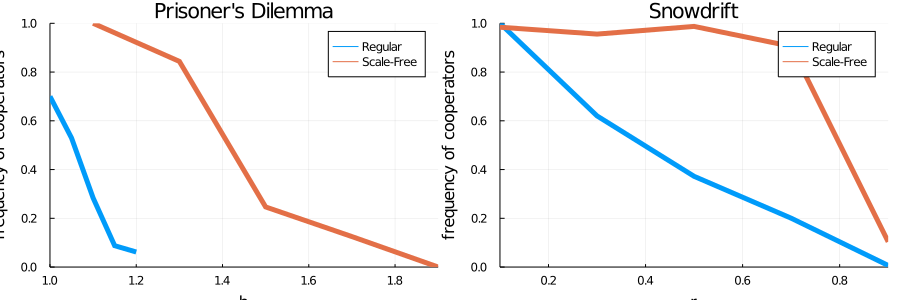

In [18]:
temp_df = df[(df.network_typ .== "Regular") .& (df.game_type .== "Prisoner's Dilemma"), :][:, [:b_r, :f_c]]
pd = plot(temp_df.b_r, temp_df.f_c, fmt = :png, 
    title="Prisoner's Dilemma", xlabel="b", ylabel="frequency of cooperators", label="Regular",
    xlims=(1,1.9), ylims=(0,1), linewidth=5)

temp_df = df[(df.network_typ .== "Scale-Free") .& (df.game_type .== "Prisoner's Dilemma"), :][:, [:b_r, :f_c]]
pd = plot!(temp_df.b_r, temp_df.f_c, fmt = :png, label="Scale-Free", linewidth=5)

temp_df = df[(df.network_typ .== "Regular") .& (df.game_type .== "Snowdrift"), :][:, [:b_r, :f_c]]
sg = plot(temp_df.b_r, temp_df.f_c, fmt = :png,
    title="Snowdrift", xlabel="r", ylabel="frequency of cooperators", label="Regular",
    xlims=(0.1,0.9), ylims=(0,1), linewidth=5)

temp_df = df[(df.network_typ .== "Scale-Free") .& (df.game_type .== "Snowdrift"), :][:, [:b_r, :f_c]]
sg = plot!(temp_df.b_r, temp_df.f_c, fmt = :png, label="Scale-Free", linewidth=5)
plot(pd, sg, size=(900, 300))